## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import PyQt5
%matplotlib inline

### Camera Calibration with OpenCV
extract object points and image points

In [16]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)
    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        cv2.imshow('img',img)
        cv2.waitKey(500)

cv2.destroyAllWindows()

calibrate distortion coefficients and run undistortion image

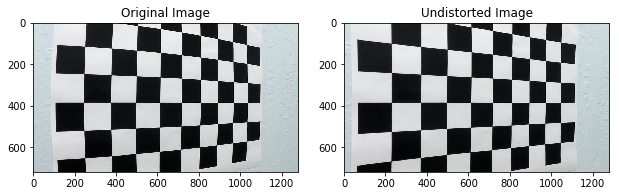

In [17]:
# Select an image
img = cv2.imread('./camera_cal/calibration5.jpg')

# Use cv2.calibrateCamera() and cv2.undistort()
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

undistorted = cv2.undistort(img, mtx, dist, None, mtx)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 6))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=12)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=12)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### Perspective Transform

<IPython.core.display.Javascript object>


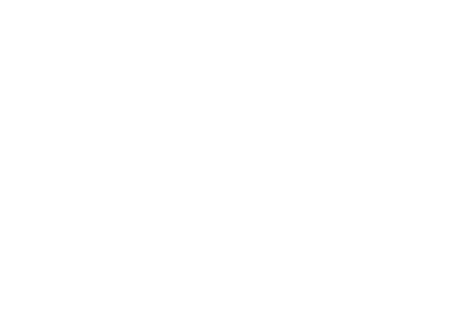

<IPython.core.display.Javascript object>


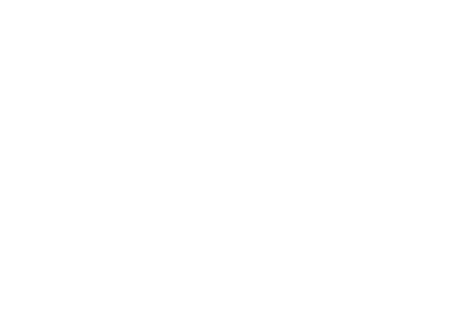

In [20]:
%matplotlib notebook
img = cv2.imread('./test_images/straight_lines2.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# Use cv2.calibrateCamera() and cv2.undistort()
undistorted = cv2.undistort(img, mtx, dist, None, mtx)
plt.imshow(undistorted)

In [21]:
%matplotlib inline

Text(0.5,1,'Warped Image')

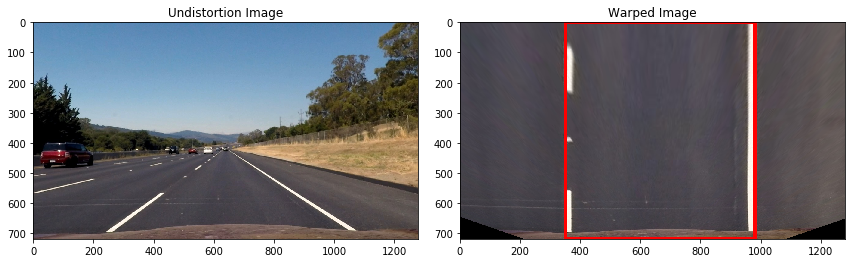

In [22]:
img = cv2.imread('./test_images/straight_lines2.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# Use cv2.calibrateCamera() and cv2.undistort()
undistorted = cv2.undistort(img, mtx, dist, None, mtx)

img_size = (undistorted.shape[1], undistorted.shape[0])
offset = 50
src = np.float32([[200,720], [563,470], [723,470], [1130,720]])
dst = np.float32([[350,720], [350,0], [980,0], [980,720]])
# The perspective transform M
M = cv2.getPerspectiveTransform(src, dst)
# The inverse perpective transform Minv
Minv = cv2.getPerspectiveTransform(dst, src)
# Warp the image using OpenCV warpPerspective()
warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
cv2.rectangle(warped,(350,720), (980,0),(255,0,0),10) 

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
f.tight_layout()
ax1.imshow(undistorted)
ax1.set_title('Undistortion Image', fontsize=12)
ax2.imshow(warped)
ax2.set_title('Warped Image', fontsize=12)

### Checkpoint

In [59]:
import pickle
# Save the camera calibration result for later use
cali_pickle = {}
cali_pickle["mtx"] = mtx
cali_pickle["dist"] = dist
cali_pickle['M'] = M
cali_pickle['Minv'] = Minv
cali_pickle['src'] = src
cali_pickle['dst'] = dst

pickle.dump(cali_pickle, open( "./data/cali_pickle.p", "wb" ) )

### Load camera matrix and distortion coefficients

In [4]:
import pickle
cali_pickle = pickle.load( open( "./data/cali_pickle.p", "rb" ) )
mtx = cali_pickle['mtx']
dist = cali_pickle['dist']
M = cali_pickle['M']
Minv = cali_pickle['Minv']
src = cali_pickle['src']
dst = cali_pickle['dst']

### Gradient Threshold

In [5]:
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    mag_sobel = np.sqrt(sobelx**2 + sobely**2)
    scaled_sobel = np.uint8(255*mag_sobel/np.max(mag_sobel))
    mag_binary = np.zeros_like(scaled_sobel)
    mag_binary [(scaled_sobel > mag_thresh[0]) & (scaled_sobel < mag_thresh[1])] = 1
    
    return mag_binary
    
def grad_thresh(img, sobel_kernel=9, dir_thresh=(0, np.pi/2)): 
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

    abs_sobelx = np.abs(sobelx)
    abs_sobely = np.abs(sobely)
    dir_sobel = np.arctan2(abs_sobely, abs_sobelx)
    dir_binary = np.zeros_like(dir_sobel)
    dir_binary[(dir_sobel > dir_thresh[0]) & (dir_sobel < dir_thresh[1])] = 1
   
    return dir_binary    

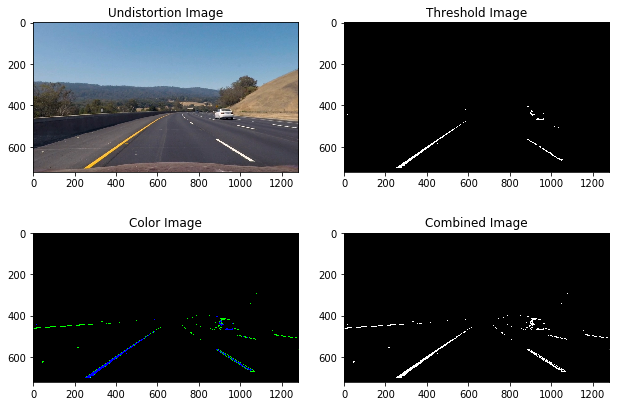

In [6]:
# Read a image
img = cv2.imread('./test_images/test3.jpg')
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Use the OpenCV undistort() function to remove distortion
undistorted = cv2.undistort(img, mtx, dist, None, mtx)
undistorted_rgb = cv2.cvtColor(undistorted, cv2.COLOR_BGR2RGB)

# Convert to HLS color space and separate the S channel
hls = cv2.cvtColor(undistorted, cv2.COLOR_BGR2HLS)
s_channel = hls[:,:,2]

# Compute the magnitude and direction of the gradient
mag_binary = mag_thresh(undistorted, sobel_kernel=3, mag_thresh=(100, 255))
dir_binary = grad_thresh(undistorted, sobel_kernel=11, dir_thresh=(0.7, np.pi/2))
# # Combinations of gradients meet threshold, magnitude, direction
# combined = np.zeros_like(dir_binary)
# combined[ ((mag_binary == 1) & (dir_binary == 1))] = 1

# Threshold color channel
s_thresh_min = 170
s_thresh_max = 255
s_binary = np.zeros_like(s_channel)
s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1
# Stack each channel to view their individual contributions in green and blue respectively
# This returns a stack of the two binary images, whose components you can see as different colors
color_binary = np.dstack(( np.zeros_like(mag_binary), mag_binary, s_binary)) * 255

# Combine the two binary thresholds
combined_binary = np.zeros_like(mag_binary)
combined_binary[(s_binary == 1) | (mag_binary == 1)] = 1

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(8, 6))
f.tight_layout()
ax1.imshow(undistorted_rgb)
ax1.set_title('Undistortion Image', fontsize=12)
ax2.imshow(s_binary, cmap='gray')
ax2.set_title('Threshold Image', fontsize=12)
ax3.imshow(color_binary)
ax3.set_title('Color Image', fontsize=12)
ax4.imshow(combined_binary, cmap='gray')
ax4.set_title('Combined Image', fontsize=12)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

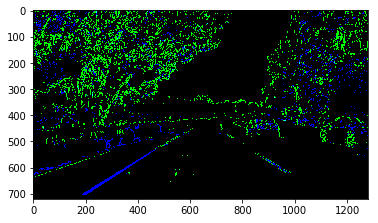

In [7]:
img = cv2.imread('./test_images/test5.jpg')
undistorted = cv2.undistort(img, mtx, dist, None, mtx)

# Edit this function to create your own pipeline.
def pipeline(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)#.astype(np.float)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0, ksize=5) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Mag sobel
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    color_binary = np.dstack((np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    return color_binary, combined_binary
    
color_binary, combined_binary = pipeline(undistorted, s_thresh=(170,250), sx_thresh=(30,100))
plt.imshow(color_binary)

### Finding the Lines

Text(0.5,1,'Warped Image')

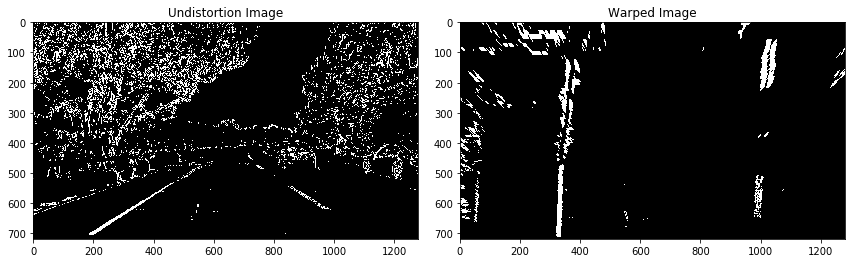

In [9]:
img = np.copy(combined_binary)
img_size = (undistorted.shape[1], undistorted.shape[0])
warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
f.tight_layout()
ax1.imshow(img, cmap='gray')
ax1.set_title('Undistortion Image', fontsize=12)
ax2.imshow(warped, cmap='gray')
ax2.set_title('Warped Image', fontsize=12)

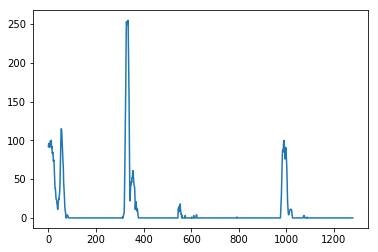

In [10]:
histogram = np.sum(warped[np.int(warped.shape[0]/2):,:], axis=0)
plt.plot(histogram)

In [11]:
out_img = np.dstack((warped, warped, warped))*255

# Choose the left and right starting points
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

In [12]:
# sliding windows number
nwindows = 9
# sliding windows height
window_height = np.int(warped.shape[0]/nwindows)
# Nonzero pixels index in the warped img
nonzero = warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])

In [13]:
# Current window position
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of windows margin
margin = 20
# Set minimum pixels to recenter window
minpix = 50
# Left and right lane pixel indices lists
left_lane_idx = []
right_lane_idx = []

for window in range(nwindows):
    # Left and right window boundaries
    win_y_low = warped.shape[0] - (window+1)*window_height
    win_y_high = win_y_low + window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    
    # Draw left window
    cv2.rectangle(out_img, (win_xleft_low, win_y_low), 
                  (win_xleft_high, win_y_high), (0,255,0),10)
    # Draw right window
    cv2.rectangle(out_img, (win_xright_low, win_y_low), 
                  (win_xright_high, win_y_high), (0,255,0),10)
    
    # Identify nonzero pixels in window
    good_left_idx = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
                    (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_idx = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
                    (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    
    # Append indices into lists
    left_lane_idx.append(good_left_idx)
    right_lane_idx.append(good_right_idx)
    
    if len(good_left_idx) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_idx]))
    if len(good_right_idx) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_idx]))

# Concatenate indices arrays
left_lane_idx = np.concatenate(left_lane_idx)
right_lane_idx = np.concatenate(right_lane_idx)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_idx]
lefty = nonzeroy[left_lane_idx] 
rightx = nonzerox[right_lane_idx]
righty = nonzeroy[right_lane_idx] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

(720, 0)

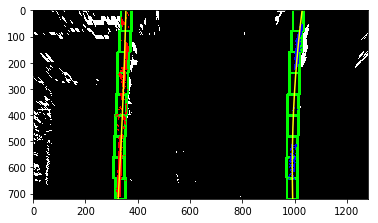

In [14]:
# Generate x and y values for plotting
ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_idx], nonzerox[left_lane_idx]] = [255, 0, 0]
out_img[nonzeroy[right_lane_idx], nonzerox[right_lane_idx]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

### Skip sliding windows step once you know lines

In [15]:
img = np.copy(combined_binary)
warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)

In [16]:
nonzero = warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])

In [17]:
left_lane_idx = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
left_fit[1]*nonzeroy + left_fit[2] + margin))) 

right_lane_idx = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
right_fit[1]*nonzeroy + right_fit[2] + margin)))  

# Again, extract left and right line pixel positions
leftx = nonzerox[left_lane_idx]
lefty = nonzeroy[left_lane_idx] 
rightx = nonzerox[right_lane_idx]
righty = nonzeroy[right_lane_idx]
# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)
# Generate x and y values for plotting
ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]


(720, 0)

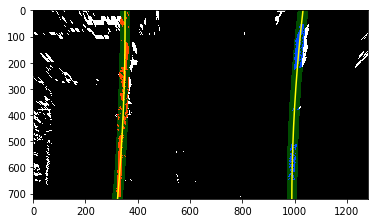

In [18]:
# Create an image to draw on and an image to show the selection window
out_img = np.dstack((warped, warped, warped))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_idx], nonzerox[left_lane_idx]] = [255, 0, 0]
out_img[nonzeroy[right_lane_idx], nonzerox[right_lane_idx]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

In [19]:
y_eval = np.max(ploty)
left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
print(left_curverad, right_curverad)

# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
# Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')

7552.85317157 6408.49565067
2453.04478219 m 2104.86014078 m


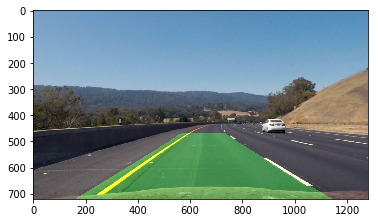

In [20]:
# Create image to draw lines
warp_zero = np.zeros_like(warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast x and y points into usable format for cv2.fillpoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))
# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image
newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0]))
# Combine the result with the original image
result = cv2.addWeighted(undistorted_rgb, 1, newwarp, 0.3, 0)
plt.imshow(result)

## And so on and so forth...

In [ ]:
cv2.putText(image_to_augment, str(variable_of_desire) , (181,71), font, 0.4, (0,0,0), 1, cv2.LINE_AA)